# Image Generation (GAN)
- 이번 실습코드는 아래의 monai tutorial의 변형으로 각자의 데이터로 GAN을 학습해보는 것이 목표입니다.
  - https://github.com/Project-MONAI/tutorials/blob/master/modules/mednist_GAN_tutorial.ipynb

- 이번 실습에서는 간단한 GAN을 이용하여 random variable을 입력으로 하여, 원하는 image를 생성하는 model을 학습합니다.
- generator와 discriminator가 어떻게 정의되고 학습이 진행되는 지를 이해하도록 합니다.
- 두 네트워크의 loss가 변하는 양상을 보며 discriminator가 학습되는 빈도를 적절하게 조절합니다.


In [ ]:
!python -c "import monai" || pip install -q monai-weekly
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
from monai.utils import progress_bar, set_determinism
from monai.transforms import (
    AddChannel,
    Compose,
    RandFlip,
    RandRotate,
    RandZoom,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
    Transform,
)
from monai.networks.nets import Discriminator, Generator
from monai.networks import normal_init
from monai.data import CacheDataset
from monai.config import print_config
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import tempfile
print_config()


MONAI version: 0.9.dev2148
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 63c18670e4d46414eb3b5917fb0632e09bc3f8ed

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### GAN 학습을 위한 주요 hyper parameter들을 설정합니다.

In [ ]:
disc_train_interval = 2
disc_train_steps = 1
batch_size = 32
latent_size = 64
max_epochs = 1800
real_label = 1
gen_label = 0
learning_rate = 1.5e-4
betas = (0.5, 0.999)

### GAN이 생성하고자 하는 유형의 image file list를 정의하여 training data loader를 생성합니다.

In [ ]:
root_dir = '/content/drive/MyDrive/data/mnist/'
print(root_dir)
path0 = '/content/drive/MyDrive/data/mnist/hufs_mnist/hufs_mnist_inv/'
imgs = [
    os.path.join(path0, x)
    for x in os.listdir(os.path.join(path0))
]
imgs[:4]

['/content/drive/MyDrive/data/mnist/hufs_mnist/hufs_mnist_inv/l_001_00.png',
 '/content/drive/MyDrive/data/mnist/hufs_mnist/hufs_mnist_inv/l_001_02.png',
 '/content/drive/MyDrive/data/mnist/hufs_mnist/hufs_mnist_inv/l_001_01.png',
 '/content/drive/MyDrive/data/mnist/hufs_mnist/hufs_mnist_inv/l_001_04.png']

In [ ]:
class LoadTarJpeg(Transform):
    def __call__(self, data):
        return plt.imread(data)


train_transforms = Compose(
    [
        LoadTarJpeg(),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandFlip(spatial_axis=1, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.2, prob=0.5),
        EnsureType(),
    ]
)

train_ds = CacheDataset(imgs, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=10
)

Loading dataset: 100%|██████████| 190/190 [00:00<00:00, 775.04it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 1, 64, 64])


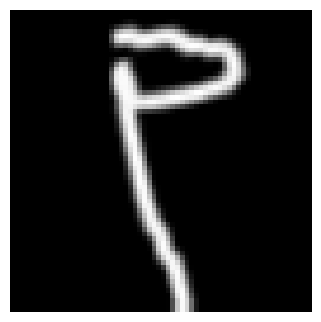

In [ ]:
dataiter=iter(train_loader)
images = dataiter.next()
print(images.shape)
I = images[0].numpy()
plt.figure(dpi=100)
plt.imshow(I[0],cmap='gray')
plt.axis('off')
plt.show()

### GAN model을 정의합니다.
- discriminator와 generator를 각각 정의합니다.
- 각각의 model을 학습하기 위한 loss function을 정의합니다.

In [ ]:
device = torch.device("cuda:0")
disc_net = Discriminator(
    in_shape=(1, 64, 64),
    channels=(8, 16, 32, 64, 1),
    strides=(2, 2, 2, 2, 1),
    num_res_units=1,
    kernel_size=5,
).to(device)


gen_net = Generator(
    latent_shape=latent_size, start_shape=(64, 8, 8),
    channels=[32, 16, 8, 1], strides=[2, 2, 2, 1],
)

# initialize both networks
disc_net.apply(normal_init)
gen_net.apply(normal_init)

# input images are scaled to [0,1] so enforce the same of generated outputs
gen_net.conv.add_module("activation", torch.nn.Sigmoid())
gen_net = gen_net.to(device)

In [ ]:
disc_loss = torch.nn.BCELoss()
gen_loss = torch.nn.BCELoss()

disc_opt = torch.optim.Adam(disc_net.parameters(), learning_rate, betas=betas)
gen_opt = torch.optim.Adam(gen_net.parameters(), learning_rate, betas=betas)


def discriminator_loss(gen_images, real_images):
    """
    The discriminator loss if calculated by comparing its
    prediction for real and generated images.

    """
    real = real_images.new_full((real_images.shape[0], 1), real_label)
    gen = gen_images.new_full((gen_images.shape[0], 1), gen_label)

    realloss = disc_loss(disc_net(real_images), real)
    genloss = disc_loss(disc_net(gen_images.detach()), gen)

    return (realloss + genloss) / 2


def generator_loss(input):
    """
    The generator loss is calculated by determining how well
    the discriminator was fooled by the generated images.

    """
    output = disc_net(input)
    cats = output.new_full(output.shape, real_label)
    return gen_loss(output, cats)

### Model 학습
- generator와 discriminator의 loss를 확인하며, hyperparameter를 최적화합니다.

In [ ]:
epoch_loss_values = [(0, 0)]
gen_step_loss = []
disc_step_loss = []
step = 0

for epoch in range(max_epochs):
    gen_net.train()
    disc_net.train()
    epoch_loss = 0

    for i, batch_data in enumerate(train_loader):

        real_images = batch_data.to(device)
        latent = torch.randn(real_images.shape[0], latent_size).to(device)

        gen_opt.zero_grad()
        gen_images = gen_net(latent)
        loss = generator_loss(gen_images)
        loss.backward()
        gen_opt.step()
        epoch_loss += loss.item()

        gen_step_loss.append((step, loss.item()))

        if step % disc_train_interval == 0:
            disc_total_loss = 0

            for _ in range(disc_train_steps):

                disc_opt.zero_grad()
                dloss = discriminator_loss(gen_images, real_images)
                dloss.backward()
                disc_opt.step()
                disc_total_loss += dloss.item()

            disc_step_loss.append((step, disc_total_loss / disc_train_steps))

        step += 1

    epoch_loss /= step
    epoch_loss_values.append((step, epoch_loss))
    print(f"epoch {epoch + 1}, avg loss: {epoch_loss_values[-1][1]:.4f}, gen step loss: {gen_step_loss[-1][1]:.4f}, disc step loss: {disc_step_loss[-1][1]:.4f}")

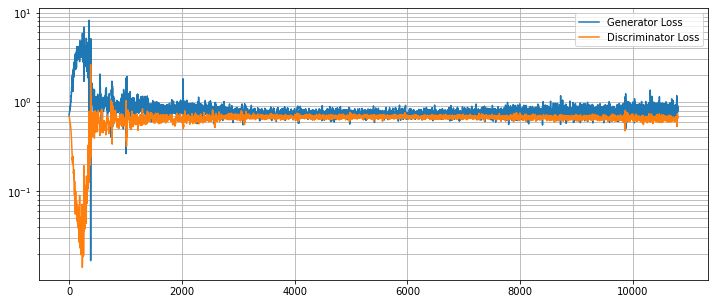

In [ ]:
plt.figure(figsize=(12, 5))
plt.semilogy(*zip(*gen_step_loss), label="Generator Loss")
plt.semilogy(*zip(*disc_step_loss), label="Discriminator Loss")
plt.grid(True, "both", "both")
plt.legend()

### Inference
- 학습된 model을 이용하여 noise input으로부터 fake image를 생성합니다.

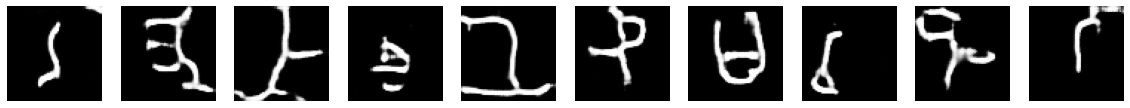

In [ ]:
test_size = 10
test_latent = torch.randn(test_size, latent_size).to(device)

test_images = gen_net(test_latent)

fig, axs = plt.subplots(1, test_size, figsize=(20, 4))

for i, ax in enumerate(axs):
    ax.axis("off")
    ax.imshow(test_images[i, 0].cpu().data.numpy(), cmap="gray")